In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags

from back_process import filtro_array


def create_fixed_degree_network(num_nodes_x, num_nodes_y, degree_x, degree_y,seed=None):

    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # Define degree sequence
    degree_sequence = [degree_x] * num_nodes_x + [degree_y] * num_nodes_y

    # Check if the sum of degrees is even
    if sum(degree_sequence) % 2 != 0:
        raise ValueError("The sum of degrees must be even to form a valid graph.")

    # Generate a random graph using the configuration model
    G = nx.configuration_model(degree_sequence)

    # Convert the multigraph to a simple graph (remove parallel edges and self-loops)
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

def create_fixed_degree_network_v2(num_nodes_x, num_nodes_y, degree_x, degree_y, seed=None):
    """
    Creates a fixed degree network with the specified parameters, ensuring the graph is a single connected component.

    Parameters:
    - num_nodes_x (int): Number of nodes of type X.
    - num_nodes_y (int): Number of nodes of type Y.
    - degree_x (int): Degree of each node of type X.
    - degree_y (int): Degree of each node of type Y.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - G (networkx.Graph): A simple, connected graph with the specified degree sequence.
    """
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # Define degree sequence
    degree_sequence = [degree_x] * num_nodes_x + [degree_y] * num_nodes_y

    # Check if the sum of degrees is even
    if sum(degree_sequence) % 2 != 0:
        raise ValueError("The sum of degrees must be even to form a valid graph.")
    
    while True:
        # Generate a random graph using the configuration model
        G = nx.configuration_model(degree_sequence)

        # Convert the multigraph to a simple graph (remove parallel edges and self-loops)
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))

        # Check if the graph is connected
        if nx.is_connected(G):
            return G

# Generate a random graph using the Erdős-Rényi model
def erdos_renyi_graph(num_nodes,probability):
    graph = nx.erdos_renyi_graph(n=num_nodes, p=probability)

    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)
    return graph

#watts_strogarz model (small-world)
def watts_strogarz_graph(n, k, p):
    graph = nx.watts_strogatz_graph(n,k,p,seed=100)

    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)

    return graph

#scale free networks
def barabasi_albert_graph(n,m):

    graph = nx.barabasi_albert_graph(n,m,seed=100)
   
    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)
    
    return graph

#stochastic_block_model
def stochastic_block_model(sizes, probs):

    graph = nx.stochastic_block_model(sizes, probs, seed=100)
   
    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)
    
    return graph

In [2]:

n, p = 500, 0.04
graph = erdos_renyi_graph(n, p)
mean_degree = p * (n - 1)
print(mean_degree)
#graph = nx.barabasi_albert_graph(300, 4)
#graph = watts_strogarz_graph(90, 10, 0.5)

19.96


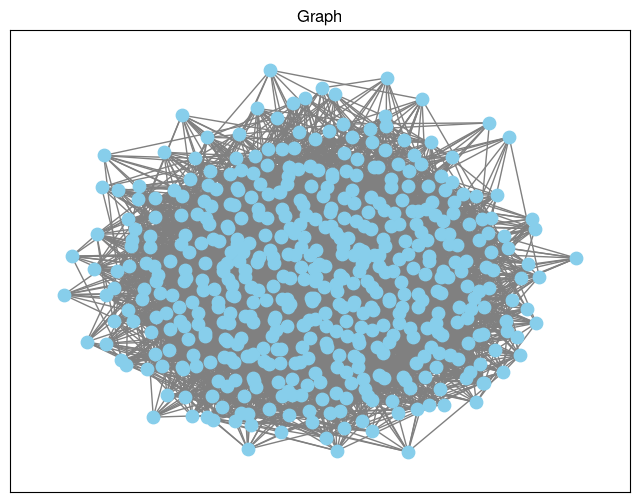

connected components: 1


In [3]:
# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=80, font_size=10)
plt.title("Graph")
plt.show()

print("connected components: "+str(nx.number_connected_components(graph)))

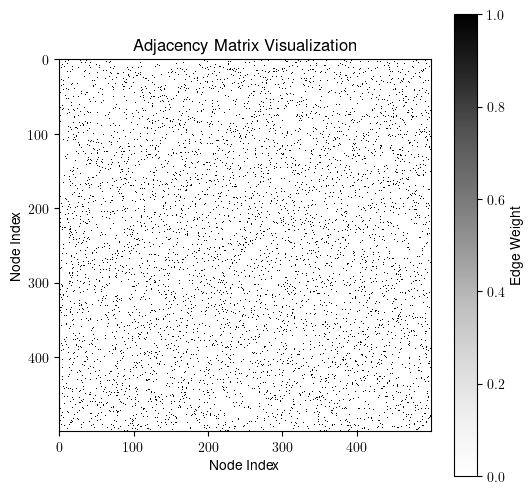

In [4]:
# Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(graph).toarray()

# Compute the Laplacian matrix
laplacian_matrix = nx.laplacian_matrix(graph).tocsc()

# Visualize the adjacency matrix as a lattice
plt.figure(figsize=(6, 6))
plt.imshow(adj_matrix, cmap='Greys', interpolation='none')
plt.colorbar(label="Edge Weight")
plt.title("Adjacency Matrix Visualization")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

In [5]:
from scipy.sparse import diags, hstack, vstack, identity
from scipy.linalg import expm

def RK4_FD(eq, fields, parameters, grids, dt, Nt, operators, t_rate): #implementa rouge-kutta
    t_grid = grids[0]
    x_grid = grids[1]
    y_grid = grids[2]
    fields_history = []
    time_grid = []
    for i in range(Nt - 1):
        old_fields = fields
        k_1 = equations_FD(eq, old_fields, t_grid[i], x_grid, y_grid, parameters, operators)
        k_2 = equations_FD(eq, old_fields + 0.5 * dt * k_1, t_grid[i], x_grid, y_grid, parameters, operators)
        k_3 = equations_FD(eq, old_fields + 0.5 * dt * k_2, t_grid[i], x_grid, y_grid, parameters, operators)
        k_4 = equations_FD(eq, old_fields + dt * k_3, t_grid[i], x_grid, y_grid, parameters, operators)
        new_fields = old_fields + dt * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
        fields = new_fields
        if i % t_rate == 0:
            fields_history.append(fields)
            time_grid.append(t_grid[i])
    return fields, fields_history, time_grid

def equations_FD(eq, field_slices, t_i, x_grid, y_grid, parameters, operators): #ecuaciones
    if eq == 'duffing':
        U = field_slices[0]
        V = field_slices[1]

        alpha = parameters[0]
        mu = parameters[1]
        gamma = parameters[2]
        k = parameters[3]
        w = parameters[4]
        DD = operators[0]

        ddU = DD @ U

        F = V
        G = - U + alpha * U ** 3 - U ** 5 - mu * V + gamma * np.cos(w * t_i) + k * ddU

        fields = np.array([F, G])
    return fields

def Der(D, f): #función de diferenciación
    d_f = D @ f
    return d_f

def time_propagator(method, I, J, Q, dt):
    if method == "I_Jdt_RK4":
        k1 = J @ Q
        k2 = J @ (Q + 0.5 * dt * k1)
        k3 = J @ (Q + 0.5 * dt * k2)
        k4 = J @ (Q + dt * k3)
        return Q + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    elif method == "exp":
        return expm(J * dt) @ Q
    elif method == "I_Jdt":
        return (I + J * dt) @ Q

def jacobians_FD(eq, fields, t_grid, x_grid, y_grid, parameters, operators):
    if eq == 'duffing':
        U_1 = fields[0]
        alpha, mu, gamma, k, w = parameters  # Unpacking parameters
        DD = operators[0]

        N = len(U_1)

        j_11 = np.zeros(N)
        j_12 = np.ones(N)
        j_21 = -1 + 3 * alpha * U_1**2 - 5 * U_1**4
        j_22 = -mu * np.ones(N)

        # Use sparse matrices directly to avoid dense conversions
        J_11 = diags(j_11, 0, format='csr')
        J_12 = diags(j_12, 0, format='csr')
        J_21 = diags(j_21, 0, format='csr') + k * DD
        J_22 = diags(j_22, 0, format='csr')

        # Efficiently construct the Jacobian matrix using sparse stacking
        J_1 = hstack([J_11, J_12], format='csr')
        J_2 = hstack([J_21, J_22], format='csr')
        J = vstack([J_1, J_2], format='csr')

        return J


In [6]:
#Definicion de parámetros

alpha = 0.4                                     # NONLINEAR COEFFICIENT
mu = 0.1                                        # DISSIPATION
gamma = 2.90#2.7  2.90                                  # DRIVE STRENGTH
k = 0.015 #0.4216 #0.028                                  # COUPLING (0.42)
w = 0.7
eq = 'duffing'
t_rate = 1

In [7]:
# Grid definition
N_nodes = n
[tmin, tmax, dt] = [0, 10000, 0.05]
t_grid = np.arange(tmin, tmax + dt, dt)         # TEMPORAL GRID DEFINITION
[xmin, xmax, dx] = [0, N_nodes, 1]
x_grid = np.arange(xmin, xmax, dx)              # SPATIAL GRID DEFINITION

T = tmax
Nt = t_grid.shape[0]
Nx = x_grid.shape[0]

# Initial Conditions
U_init = 1.0 * np.ones(Nx)
initial_quimera = 18
arg_chimera = [initial_quimera]                             # INITIAL QUIMERA INDEX
for i in arg_chimera:
    U_init[i] = 2.0
U_init = U_init + 0.0 * (np.random.rand(Nx) - 0.5)
V_init = 0.0 * np.random.rand(Nx)

In [8]:
# Empaquetamiento de parametros, campos y derivadas para integración
operators = [laplacian_matrix]
fields_init = [U_init, V_init]
grids = [t_grid, x_grid, 0]
parameters_np = np.array([alpha, mu, gamma, k, w])

In [9]:
final_fields, fields_history, time_grid = RK4_FD(eq, fields_init, parameters_np, grids, dt, Nt, operators, t_rate)      #NUMERICAL SIMULATION

In [10]:
# Reobteniendo campos y variables
U = np.array(fields_history)[:, 0]
V = np.array(fields_history)[:, 1]
phase = np.arctan2(V, U)    #Harmonic oscillator can be writen as R * exp (i * phase) with R = SQRT(U ** 2 + V ** 2) and phase = arctan(V/U)
lightness = 1
U_light = U[0::lightness]
V_light = V[0::lightness]
phase_light_wraped = phase[0::lightness]
phase_light = np.unwrap(phase_light_wraped, axis=0)[0::lightness]
t_light = np.array(time_grid[0::lightness])
module = np.sqrt(U_light ** 2 + V_light ** 2) ## AMPLITUDE / MODULE

In [11]:
############### GENERIC INITIAL AND FINAL TIME ###############
t_init = 9800
t_final = 10000
i_0 = np.argmin(np.abs(t_light - t_init))
i_f = np.argmin(np.abs(t_light - t_final))

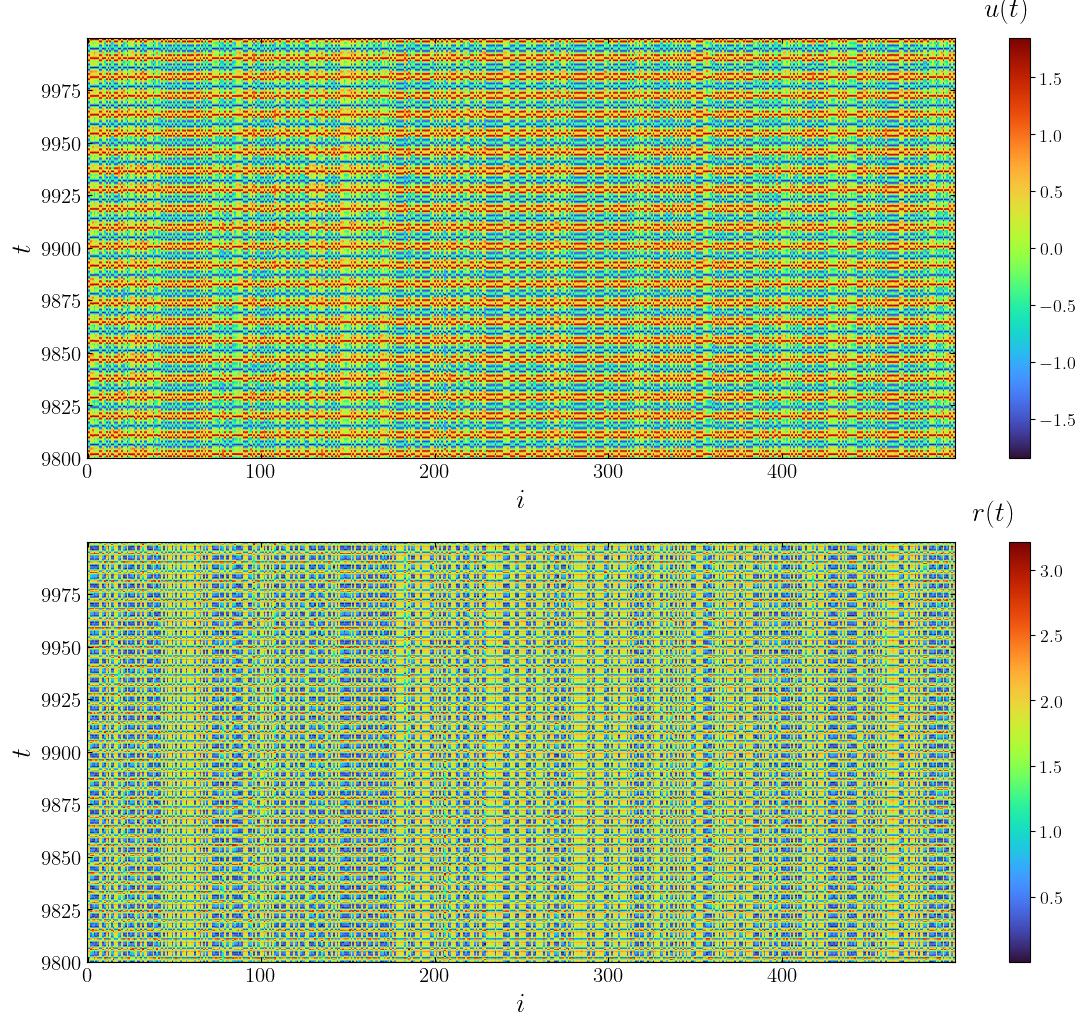

In [12]:
############### SPATIOTEMPORAL DYNAMICS OF QUIMERAS BY NODE LABEL ###############

fig, (ax01, ax02) = plt.subplots(2, 1, figsize=(14, 12))
cax_01 = ax01.pcolormesh(x_grid, t_light[i_0:i_f], U_light[i_0:i_f, :], cmap="turbo", shading='auto')
cbar = fig.colorbar(cax_01)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('$u(t)$', rotation=0, size=20, labelpad=-50, y=1.1)
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax01.set_xlabel("$i$", fontsize=20)
ax01.set_ylabel("$t$", fontsize=20)

cax_02 = ax02.pcolormesh(x_grid, t_light[i_0:i_f], module[i_0:i_f, :], cmap="turbo", shading='auto')
cbar = fig.colorbar(cax_02)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('$r(t)$', rotation=0, size=20, labelpad=-50, y=1.1)
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax02.set_xlabel("$i$", fontsize=20)
ax02.set_ylabel("$t$", fontsize=20)

figure_dir = "C:/Users/Rafa/PycharmProjects/LENL_simulations/00_projects/network_chimeras/simulations/figures"
plt.savefig(figure_dir + '/fig_chimeras.png', dpi=300)

(9800.0, 10000.0)

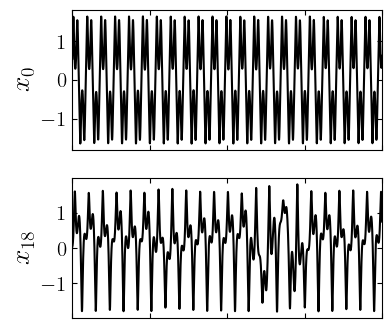

In [13]:
### VISUALIZATION OF TIME SERIES OF TWO DIFERENT NODES

ind1 = 0
ind2 = initial_quimera

fig, (ax01, ax02) = plt.subplots(2, 1, figsize=(4, 4))
ax01.plot(t_light[i_0:i_f], U_light[i_0:i_f, ind1], color="k")
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax01.set_ylabel("$x_{{" + str(ind1) + "}}$", fontsize=20)
ax01.set_xlim(t_init, t_final)

ax02.plot(t_light[i_0:i_f], U_light[i_0:i_f, ind2], color="k")
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax02.set_ylabel("$x_{{" + str(ind2) + "}}$", fontsize=20)
ax02.set_xlim(t_init, t_final)

(9800.0, 10000.0)

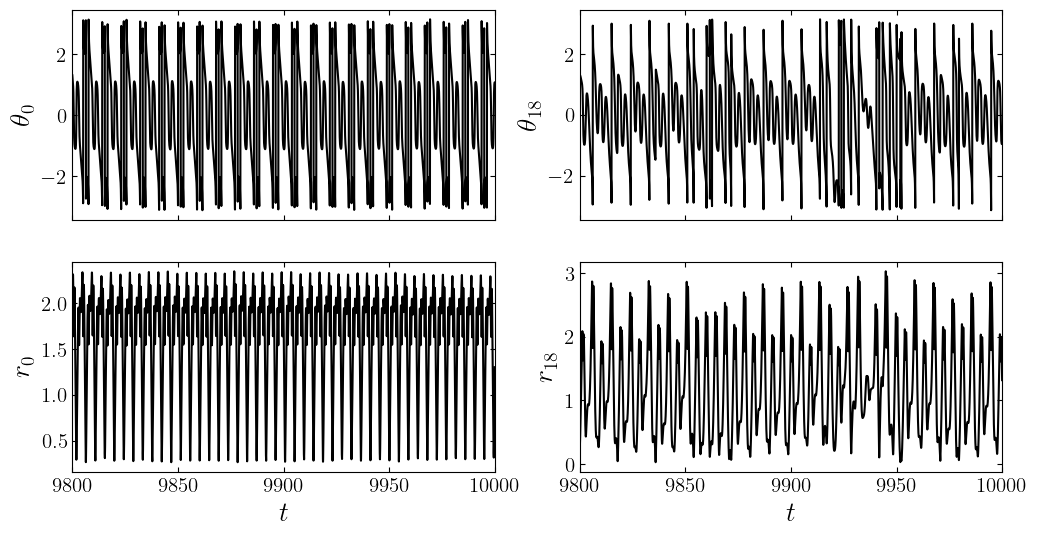

In [14]:
### WRAPED PHASE (CONTINUA EN EL TIEMPO) FOR TWO DIFFERENT NODES
### SI SE HACE UN GRAFICO DE ESTO, HAY QUE GRAFICAR UN SOLO PERIODO

fig, ((ax01, ax02), (ax03, ax04)) = plt.subplots(2, 2, figsize=(12, 6))

ax01.plot(t_light[i_0:i_f], phase_light_wraped[i_0:i_f, ind1], color="k")
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax01.set_ylabel("$\\theta_{{" + str(ind1) + "}}$", fontsize=20)
ax01.set_xlim(t_init, t_final)

ax02.plot(t_light[i_0:i_f], phase_light_wraped[i_0:i_f, ind2], color="k")
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax02.set_ylabel("$\\theta_{{" + str(ind2) + "}}$", fontsize=20)
ax02.set_xlim(t_init, t_final)

ax03.plot(t_light[i_0:i_f], module[i_0:i_f, ind1], color="k")
ax03.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax03.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax03.set_ylabel("$r_{{" + str(ind1) + "}}$", fontsize=20)
ax03.set_xlim(t_init, t_final)
ax03.set_xlabel("$t$", fontsize=20)

ax04.plot(t_light[i_0:i_f], module[i_0:i_f, ind2], color="k")
ax04.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax04.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax04.set_ylabel("$r_{{" + str(ind2) + "}}$", fontsize=20)
ax04.set_xlabel("$t$", fontsize=20)
ax04.set_xlim(t_init, t_final)

Text(0.5, 0, '$i$')

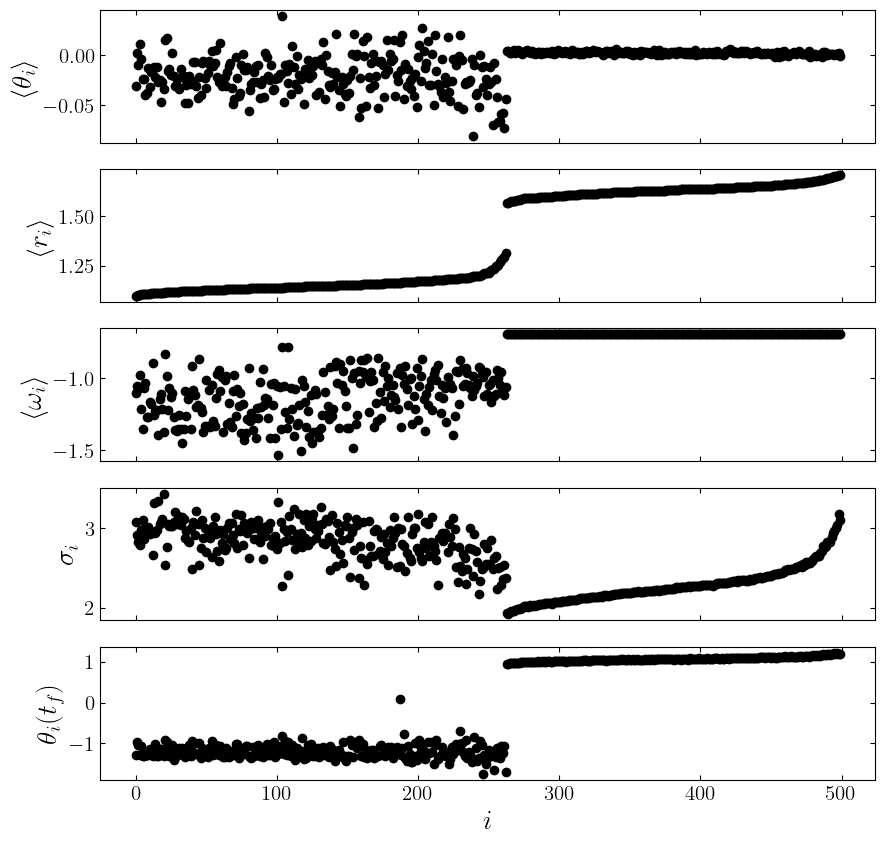

In [15]:
from scipy import integrate

############## AVERAGES AND CHARACTERIZATION OF THE STATIONARY FINAL STATE N = (10000, 20000)##############

t_init = 9000
t_final = 10000
i_0 = np.argmin(np.abs(t_light - t_init))
i_f = np.argmin(np.abs(t_light - t_final))

average_phase = integrate.simpson(phase_light_wraped[i_0:i_f], t_grid[i_0:i_f], axis=0) / (t_grid[i_f] - t_grid[i_0]) ## AVERAGE WRAPPED PHASE
omega_average = integrate.simpson(np.diff(phase_light, axis=0)[i_0:i_f] / dt, t_grid[i_0:i_f], axis=0) / (t_grid[i_f] - t_grid[i_0]) ## AVERAGE FREQUENCY
sigma2_phase = integrate.simpson((phase_light[i_0:i_f] - average_phase) ** 2, t_grid[i_0:i_f], axis=0) / (t_grid[i_f] - t_grid[i_0])  ## FREQUENCY STANDARD DEVIATION
sigma2 = integrate.simpson(((np.diff(phase_light, axis=0)[i_0:i_f] / dt) - omega_average) ** 2, t_grid[i_0:i_f], axis=0) / (t_grid[i_f] - t_grid[i_0])  ## FREQUENCY STANDARD DEVIATION
average_module = integrate.simpson(module[i_0:i_f], t_grid[i_0:i_f], axis=0) / (t_grid[i_f] - t_grid[i_0])

args = np.argsort(average_module)  ## ACA SE ORDENA

fig, (ax01, ax02, ax03, ax04, ax05) = plt.subplots(5, 1, figsize=(10, 10))

ax01.scatter(x_grid, average_phase[args], color="k")
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax01.set_ylabel("$\\langle \\theta_i \\rangle$", fontsize=20)

ax02.scatter(x_grid, average_module[args], color="k")
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax02.set_ylabel("$\\langle  r_i \\rangle$", fontsize=20)

ax03.scatter(x_grid, omega_average[args], color="k")
ax03.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax03.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax03.set_ylabel("$\\langle \\omega_i \\rangle$", fontsize=20)

ax04.scatter(x_grid, np.sqrt(sigma2[args]), color="k")
ax04.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax04.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax04.set_ylabel("$\\sigma_i$", fontsize=20)

ax05.scatter(x_grid, phase_light_wraped[-1, args], color="k")
ax05.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax05.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax05.set_ylabel("$\\theta_i(t_f)$", fontsize=20)
ax05.set_xlabel("$i$", fontsize=20)


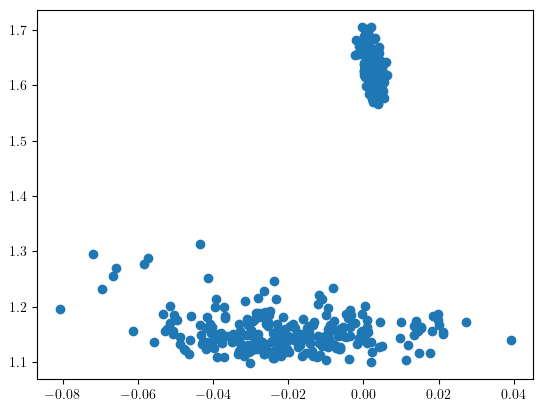

In [16]:
plt.scatter(average_phase[args], average_module[args])
plt.show()

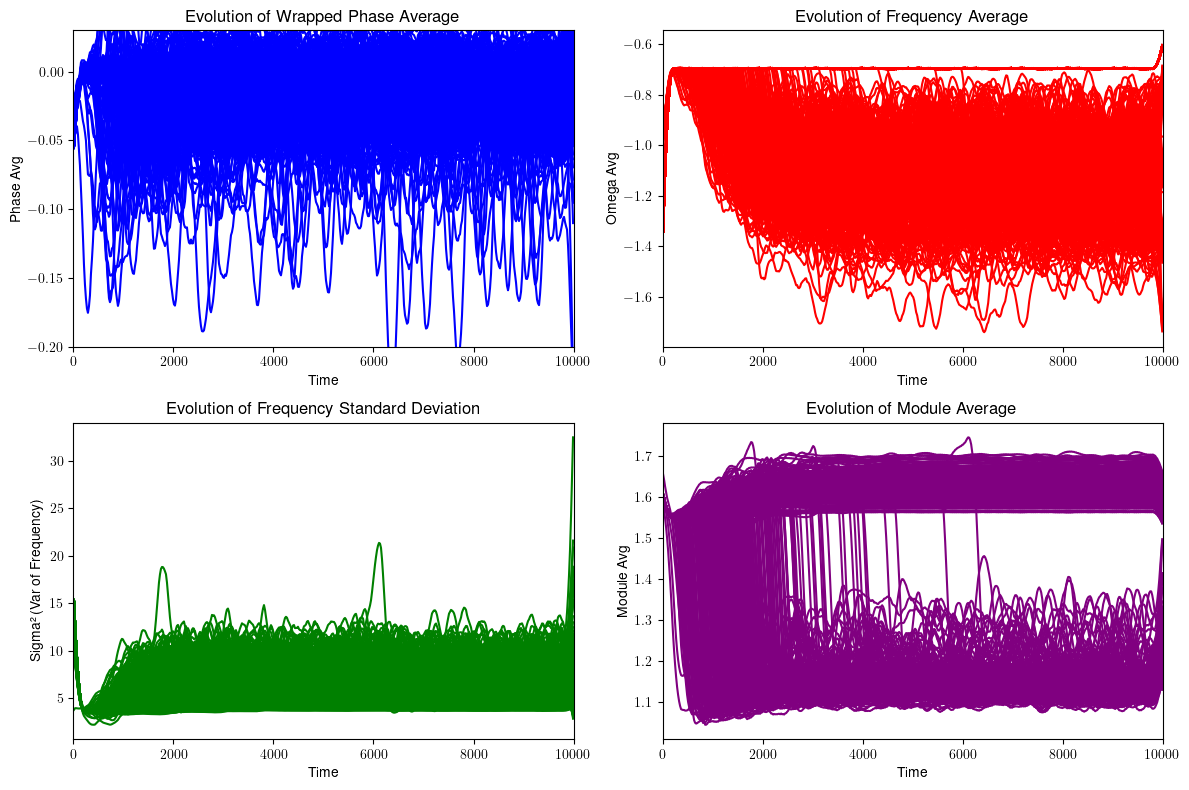

In [18]:
from scipy.signal import filtfilt
d_phase_dt = np.diff(phase_light, axis=0) / dt

def filtro_array(n, funcion):
    # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    Z_filtered = filtfilt(b, a, funcion)
    return Z_filtered

def filtro_superficie(Z, intensidad, sentido):
    X_len = len(Z[:, 0])
    Y_len = len(Z[0, :])
    FILT = np.zeros((X_len, Y_len))
    if sentido == 'X':
        for i in range(X_len):
            filtered = filtro_array(intensidad, Z[i, :])
            FILT[i, :] = filtered
    elif sentido == 'Y':
        for i in range(Y_len):
            filtered = filtro_array(intensidad, Z[:, i])
            FILT[:, i] = filtered
    elif sentido == 'XY':
        for i in range(X_len):
            filtered = filtro_array(intensidad, Z[i, :])
            FILT[i, :] = filtered
        for i in range(Y_len):
            filtered = filtro_array(intensidad, FILT[:, i])
            FILT[:, i] = filtered
    elif sentido == 'YX':
        for i in range(Y_len):
            filtered = filtro_array(intensidad, Z[:, i])
            FILT[:, i] = filtered
        for i in range(X_len):
            filtered = filtro_array(intensidad, FILT[i, :])
            FILT[i, :] = filtered
    return FILT

# Define the sliding window size
window_size = int(20 / dt)  # Number of time steps in each window
time_avg = []
phase_avg_series = []
omega_avg_series = []
sigma2_series = []
module_avg_series = []

# Compute moving averages
for i in range(0, Nt - window_size, window_size):
    i_0, i_f = i, i + window_size

    avg_phase = integrate.simpson(phase_light_wraped[i_0:i_f], t_grid[i_0:i_f], axis=0) / (t_grid[i_f] - t_grid[i_0])
    avg_omega = integrate.simpson(d_phase_dt[i_0:i_f - 1], t_grid[i_0:i_f - 1], axis=0) / (t_grid[i_f] - t_grid[i_0])
    avg_sigma2 = integrate.simpson((d_phase_dt[i_0:i_f - 1] - avg_omega) ** 2, t_grid[i_0:i_f - 1], axis=0) / (t_grid[i_f] - t_grid[i_0])
    avg_module = integrate.simpson(module[i_0:i_f], t_grid[i_0:i_f], axis=0) / (t_grid[i_f] - t_grid[i_0])

    time_avg.append(t_grid[i_0 + window_size // 2])  # Mid-time of the window
    phase_avg_series.append(avg_phase)
    omega_avg_series.append(avg_omega)
    sigma2_series.append(avg_sigma2)
    module_avg_series.append(avg_module)

# Convert to arrays
time_avg = np.array(time_avg)
phase_avg_series = filtro_superficie(np.array(phase_avg_series), 10, "Y")
omega_avg_series = filtro_superficie(np.array(omega_avg_series), 10, "Y")
sigma2_series = filtro_superficie(np.array(sigma2_series), 10, "Y")
module_avg_series = filtro_superficie(np.array(module_avg_series), 10, "Y")

# Plot the evolution of parameters
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(time_avg, phase_avg_series, label="Average Wrapped Phase", color="blue")
plt.xlabel("Time")
plt.ylabel("Phase Avg")
plt.title("Evolution of Wrapped Phase Average")
plt.xlim(0, 10000)
plt.ylim(-0.2, 0.03)

plt.subplot(2, 2, 2)
plt.plot(time_avg, omega_avg_series, label="Average Frequency", color="red")
plt.xlabel("Time")
plt.ylabel("Omega Avg")
plt.title("Evolution of Frequency Average")
plt.xlim(0, 10000)

plt.subplot(2, 2, 3)
plt.plot(time_avg, sigma2_series, label="Frequency Std Dev", color="green")
plt.xlabel("Time")
plt.ylabel("Sigma² (Var of Frequency)")
plt.title("Evolution of Frequency Standard Deviation")
plt.xlim(0, 10000)

plt.subplot(2, 2, 4)
plt.plot(time_avg, module_avg_series, label="Average Module", color="purple")
plt.xlabel("Time")
plt.ylabel("Module Avg")
plt.title("Evolution of Module Average")
plt.xlim(0, 10000)

plt.tight_layout()
plt.show()


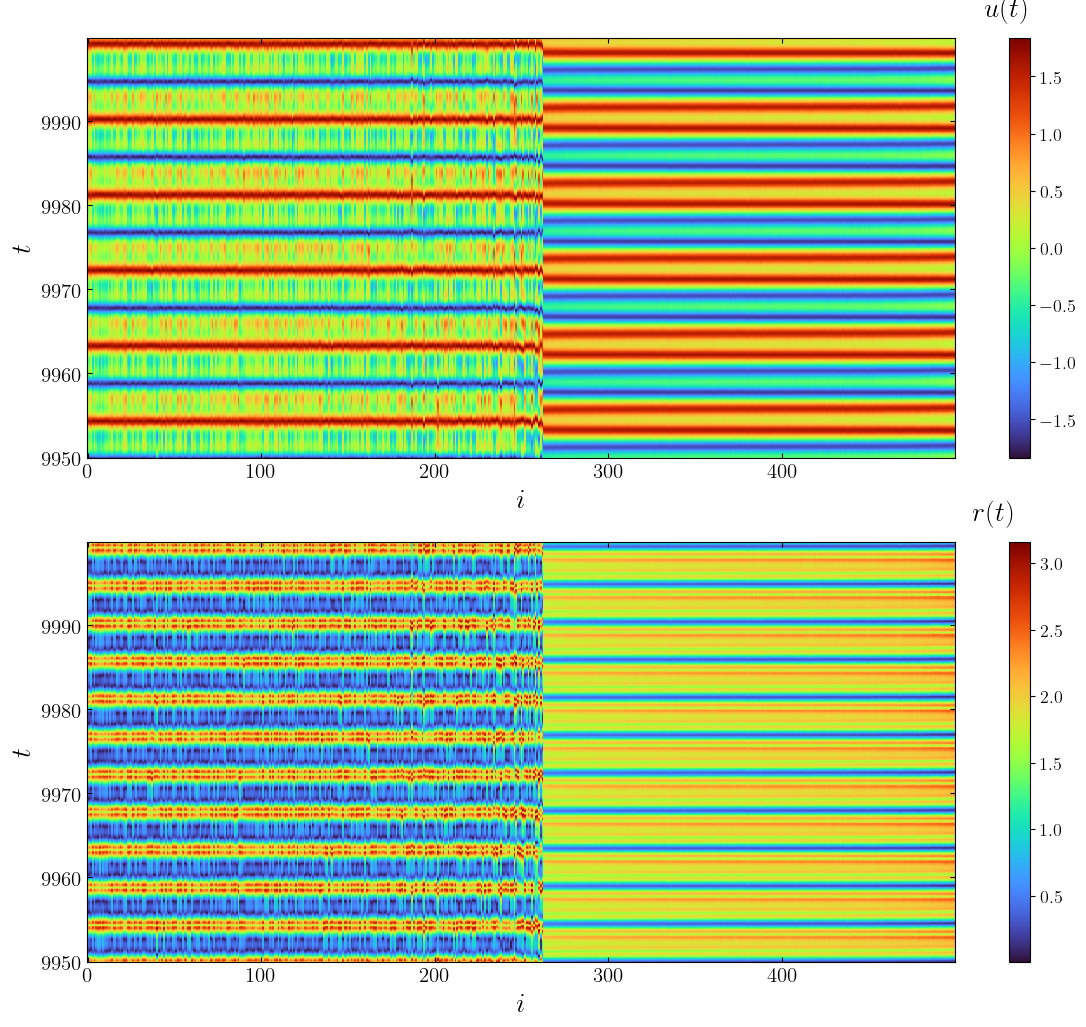

In [19]:
############## SPATIOTEMPORAL DYNAMICS OF QUIMERAS SORTED BY PHASE/AMPLITUDE ##############
t_init = 9950
t_final = 10000
i_0 = np.argmin(np.abs(t_light - t_init))
i_f = np.argmin(np.abs(t_light - t_final))

list_spl = np.array([nx.shortest_path_length(graph, source=18, target=i) for i in graph.nodes()])
arg_spl = np.argsort(list_spl)

fig, (ax01, ax02) = plt.subplots(2, 1, figsize=(14, 12))
cax_01 = ax01.pcolormesh(x_grid, t_light[i_0:i_f], U_light[i_0:i_f, args], cmap="turbo", shading='auto')
cbar = fig.colorbar(cax_01)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('$u(t)$', rotation=0, size=20, labelpad=-50, y=1.1)
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax01.set_xlabel("$i$", fontsize=20)
ax01.set_ylabel("$t$", fontsize=20)

cax_02 = ax02.pcolormesh(x_grid, t_light[i_0:i_f], module[i_0:i_f, args], cmap="turbo", shading='auto')
cbar = fig.colorbar(cax_02)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('$r(t)$', rotation=0, size=20, labelpad=-50, y=1.1)
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax02.set_xlabel("$i$", fontsize=20)
ax02.set_ylabel("$t$", fontsize=20)
plt.show()


0.526


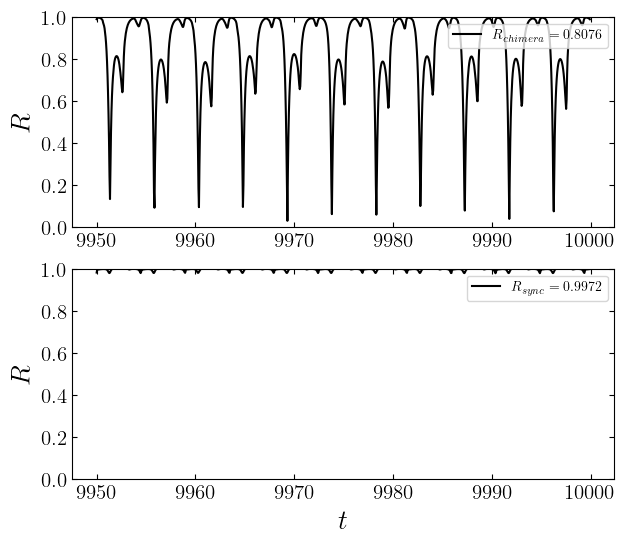

In [21]:
############## MEASURING SYNCRONIZATION WITH ORDER PARAMETER R ##############
power_threshold = 1.5
arg_chimeras = average_module < power_threshold
arg_sync = average_module >= power_threshold
frac_chimera = len(average_module[arg_chimeras]) / N_nodes
R_quim = (1 / len(phase_light[0, arg_chimeras]))* np.abs(np.sum(np.exp(1j * phase_light[:, arg_chimeras]), axis=1))
R_sync = (1 / len(phase_light[0, arg_sync])) * np.abs(np.sum(np.exp(1j * phase_light[:, arg_sync]), axis=1))

print(frac_chimera) ############ ACA ESTA LA FRACCIÓN DE NC/N

fig, (ax01, ax02) = plt.subplots(2, 1, figsize=(7, 6))

ax01.plot(t_light[i_0:i_f], R_quim[i_0:i_f], color="k", label="$R_{chimera} = " + f"{np.mean(R_quim):.{4}f}" + "$")
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax01.set_ylabel("$R$", fontsize=20)
ax01.set_ylim(0, 1)
ax01.legend(loc="upper right")

ax02.plot(t_light[i_0:i_f], R_sync[i_0:i_f], color="k", label="$R_{sync} = " + f"{np.mean(R_sync):.{4}f}" + "$")
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax02.set_xlabel("$t$", fontsize=20)
ax02.set_ylabel("$R$", fontsize=20)
ax02.set_ylim(0, 1)
ax02.legend(loc="upper right")

plt.show()
plt.close()

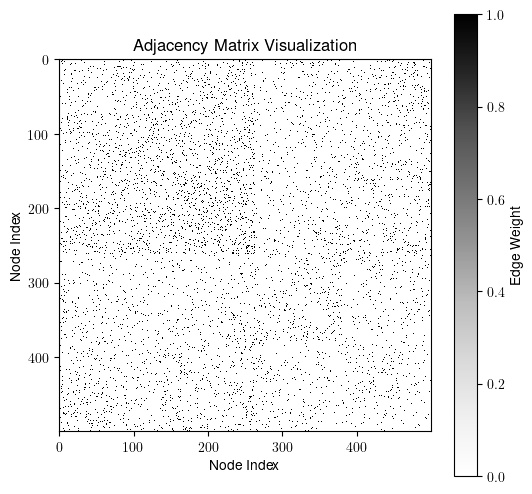

In [22]:
############## ADJ MATRIX IN SORTED BASE ##############
P = np.eye(N_nodes)[args]
adj_sorted = P @ adj_matrix @ P.T
plt.figure(figsize=(6, 6))
plt.imshow(adj_sorted, cmap='Greys', interpolation='none')
plt.colorbar(label="Edge Weight")
plt.title("Adjacency Matrix Visualization")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

0.038076152304609215


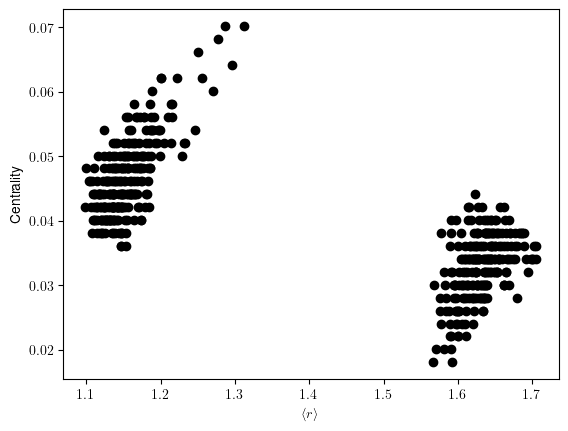

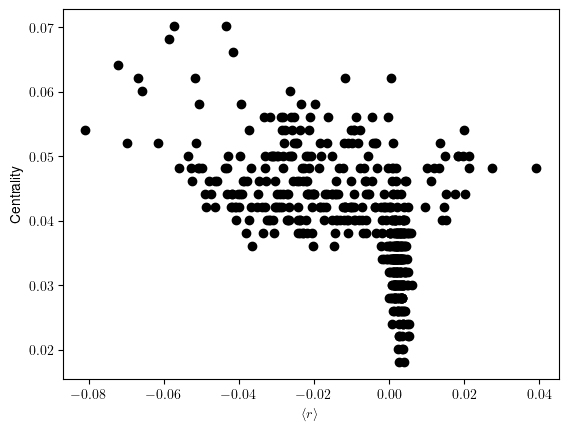

In [23]:
############## CENTRALITY VS PHASE / MODULE ##############

centrality = nx.degree_centrality(graph)
node_centrality = list(centrality.values())
print(node_centrality[30])
plt.scatter(average_module, node_centrality, c="k")
plt.ylabel("Centrality")
plt.xlabel("$\\langle r \\rangle$")
plt.show()
plt.close()

plt.scatter(average_phase, node_centrality, c="k")
plt.ylabel("Centrality")
plt.xlabel("$\\langle r \\rangle$")
plt.show()
plt.close()

In [130]:
############## LYAPUNOV SPECTRUM ANALYSIS ##############

T_00 = int(0.999 * Nt)
T_01 = int(1.00 * Nt)
I = np.eye(2 * Nx)
lyap_01 = []
N_condit = int(2 * Nx)
U_init = np.random.rand(2 * Nx, N_condit) - 0.5
Q, R = np.linalg.qr(U_init)
for i in range(T_00, T_01 - 1):
    U_1 = U_light[i, :]
    U_2 = V_light[i, :]
    J = jacobians_FD(eq, [U_1, U_2], t_grid, x_grid, [0], parameters_np, operators)
    Q_new = time_propagator("I_Jdt_RK4", I, J, Q, dt)
    Q, R = np.linalg.qr(Q_new)
    Q = Q
    lyap_01.append(np.log(np.absolute(R.diagonal())) / dt)
lyap_01 = np.array(lyap_01)
lyap_mean_01 = []
average_Nt_i = T_00
for i in range(N_condit):
    lyap_mean_01.append(np.sum(lyap_01[:, i]))
lyap_mean_01 = np.array(lyap_mean_01) / len(lyap_01[:, 0])

KeyboardInterrupt: 

In [64]:
############## LYAPUNOV SPECTRUM ANALYSIS ##############
import scipy.linalg

T_00 = int(0.995 * Nt)
T_01 = int(1.00 * Nt)
I = np.eye(2 * Nx)

N_condit = 2 * Nx
U_init = np.random.rand(N_condit, N_condit) - 0.5
Q, _ = np.linalg.qr(U_init)  # Only Q is needed

# Preallocate Lyapunov exponent storage for speed
lyap_01 = np.zeros((T_01 - T_00 - 1, N_condit))

for i in range(T_00, T_01 - 1):
    U_1, U_2 = U_light[i, :], V_light[i, :]
    J = jacobians_FD(eq, [U_1, U_2], t_grid, x_grid, [0], parameters_np, operators)

    # Compute the time propagator and update Q
    Q_new = time_propagator("I_Jdt_RK4", I, J, Q, dt)
    Q, R = scipy.linalg.qr(Q_new, overwrite_a=True, mode='economic')  # QR decomposition

    # Store log of absolute diagonal of R divided by dt
    lyap_01[i - T_00, :] = np.log(np.abs(np.diag(R))) / dt

# Compute the mean Lyapunov exponents
lyap_mean_01 = np.mean(lyap_01, axis=0)

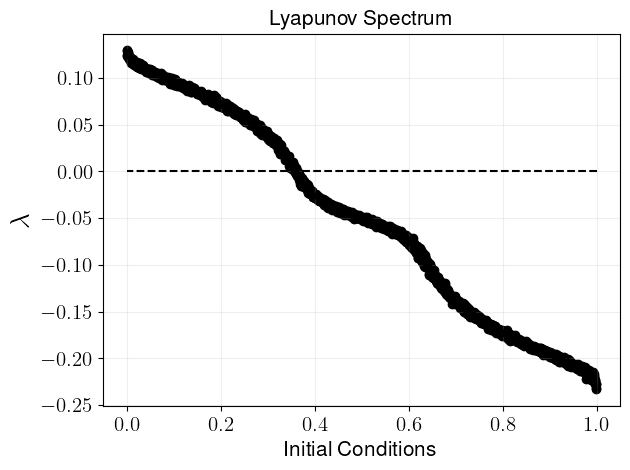

In [65]:
############## LYAPUNOV SPECTRUM VS INDEX OF MODES USED AS INITIAL CONDITION ##############

x = np.arange(N_condit) / N_condit
plt.plot(x, lyap_mean_01, c="k", linewidth=2)
plt.scatter(x, lyap_mean_01, color="k")
plt.hlines(0, 1, 0, color="k", linestyle="--")
plt.title("Lyapunov Spectrum", size='15')
plt.xlabel('Initial Conditions', size='15')
plt.xticks(fontsize=15)
plt.ylabel('$\\lambda$', size='20')
plt.yticks(fontsize=15)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('lyap_espectrums.png', dpi=300)
plt.show()

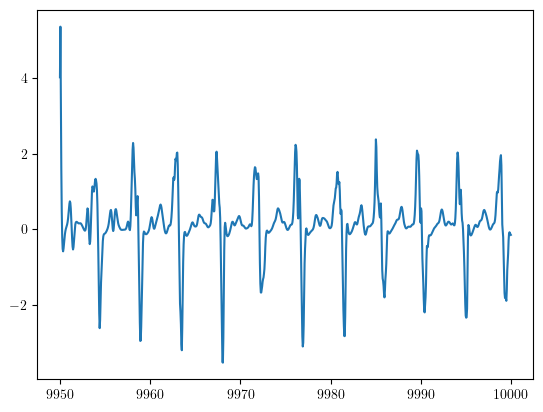

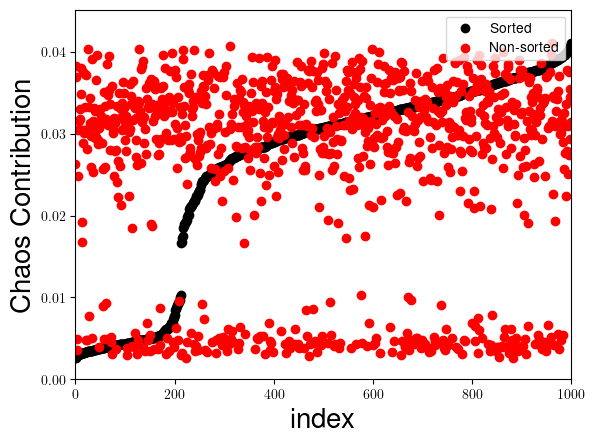

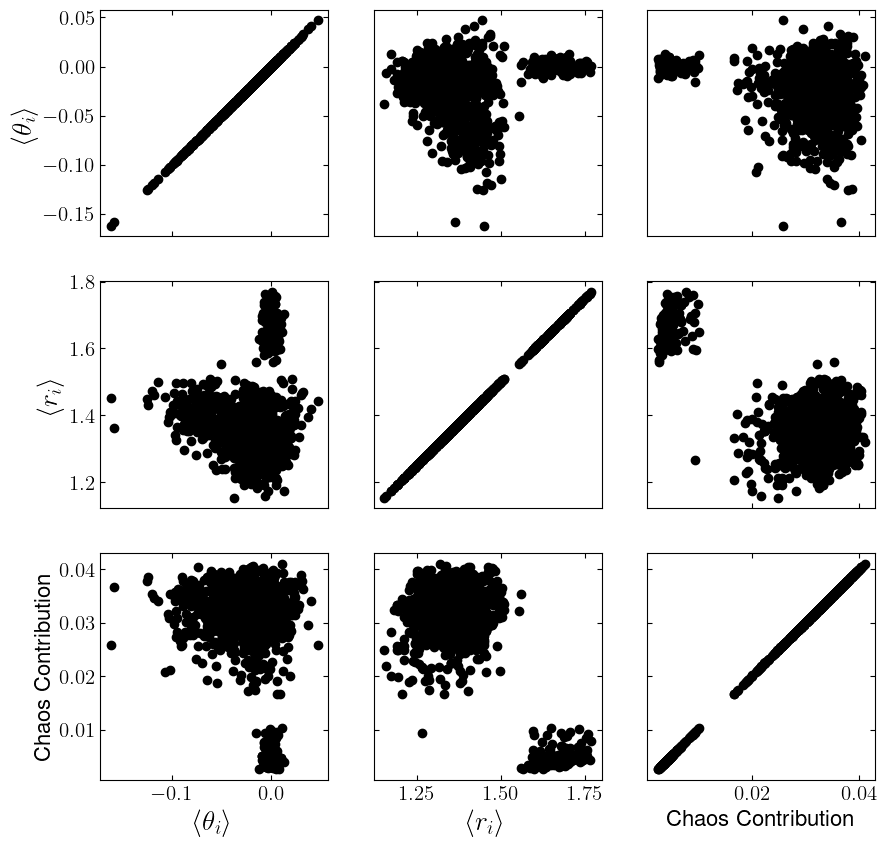

In [66]:
############## LYAPUNOV SPECTRUM VS INDEX OF MODES USED AS INITIAL CONDITION ##############

arg_lyap_pos = lyap_mean_01 >= 0.0
Q_pos = (np.sum(np.abs(Q[:N_nodes, arg_lyap_pos]) + np.abs(Q[N_nodes:, arg_lyap_pos]), axis=1)) / (len(lyap_mean_01[arg_lyap_pos]))
args_lyap_modes = np.argsort(Q_pos)

plt.plot(t_grid[T_00:T_01-1], lyap_01[:, 30])
plt.show()
plt.close()

plt.scatter(x_grid, Q_pos[args_lyap_modes], c="k", label="Sorted")
plt.scatter(x_grid, Q_pos, c="r", label="Non-sorted")
plt.xlabel("index", fontsize=20)
plt.ylabel("Chaos Contribution", fontsize=20)
plt.legend(loc="upper right")
plt.xlim(0, N_nodes)
plt.ylim(0, 1.1 * np.amax(Q_pos))
plt.show()
plt.close()

fig, ((ax00, ax01, ax02), (ax10, ax11, ax12), (ax20, ax21, ax22)) = plt.subplots(3, 3, figsize=(10, 10))

ax00.scatter(average_phase, average_phase, color="k")
ax00.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax00.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax00.set_ylabel("$\\langle \\theta_i \\rangle$", fontsize=20)

ax01.scatter(average_module, average_phase, color="k")
ax01.tick_params(axis="y", direction="in", labelsize=15, left=False, right=True, labelleft=False, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)

ax02.scatter(Q_pos, average_phase, color="k")
ax02.tick_params(axis="y", direction="in", labelsize=15, left=False, right=True, labelleft=False, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)

##################################################################

ax10.scatter(average_phase, average_module, color="k")
ax10.tick_params(axis="y", direction="in", labelsize=15, left=True, right=False, labelleft=True, labelright=False)
ax10.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=False, labeltop=False, labelbottom=False)
ax10.set_ylabel("$\\langle r_i \\rangle$", fontsize=20)

ax11.scatter(average_module, average_module, color="k")
ax11.tick_params(axis="y", direction="in", labelsize=15, left=True, right=False, labelleft=False, labelright=False)
ax11.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=False, labeltop=False, labelbottom=False)

ax12.scatter(Q_pos, average_module, color="k")
ax12.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=False, labelright=False)
ax12.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)

##################################################################

ax20.scatter(average_phase, Q_pos, color="k")
ax20.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax20.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax20.set_xlabel("$\\langle \\theta_i \\rangle$", fontsize=20)
ax20.set_ylabel("Chaos Contribution", fontsize=16)

ax21.scatter(average_module, Q_pos, color="k")
ax21.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=False, labelright=False)
ax21.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax21.set_xlabel("$\\langle r_i \\rangle$", fontsize=20)

ax22.scatter(Q_pos, Q_pos, color="k")
ax22.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=False, labelright=False)
ax22.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax22.set_xlabel("Chaos Contribution", fontsize=16)

plt.show()

Text(0, 0.5, '$t$')

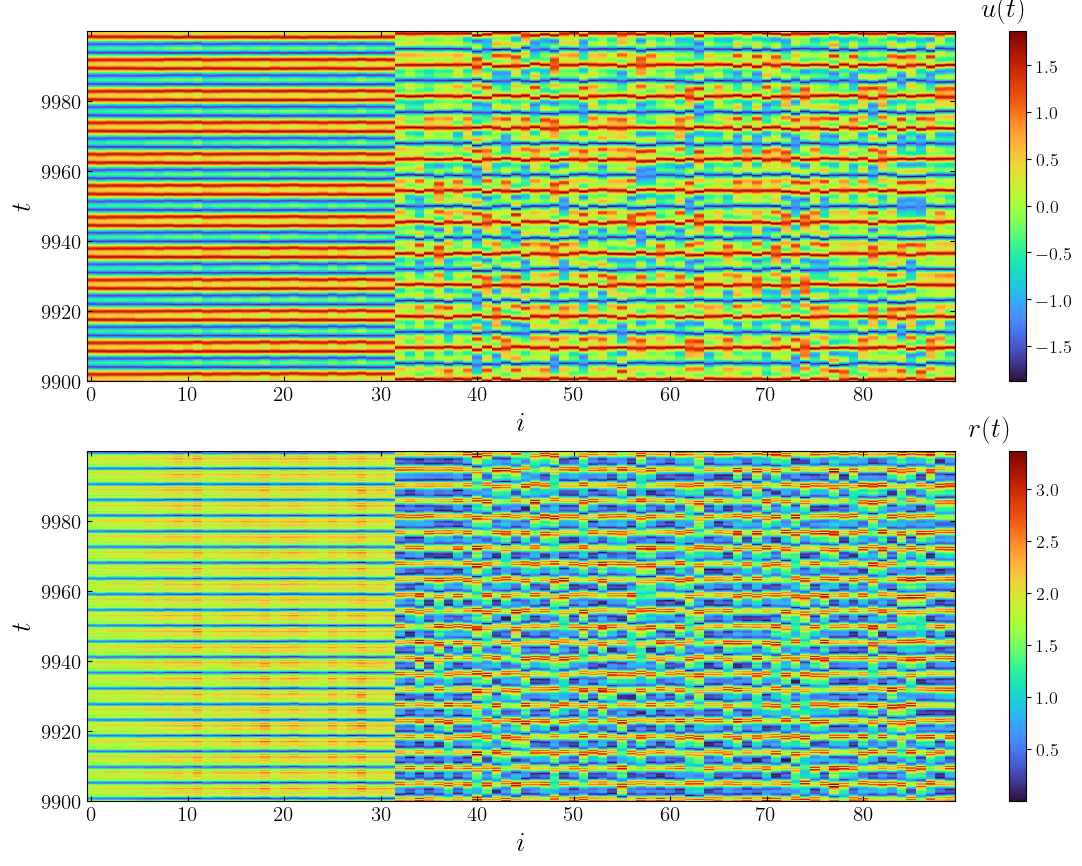

In [93]:
t_init = 9900
t_final = 10000
i_0 = np.argmin(np.abs(t_light - t_init))
i_f = np.argmin(np.abs(t_light - t_final))

fig, (ax01, ax02) = plt.subplots(2, 1, figsize=(14, 10))
cax_01 = ax01.pcolormesh(x_grid, t_light[i_0:i_f], U_light[i_0:i_f, args_lyap_modes], cmap="turbo", shading='auto')
cbar = fig.colorbar(cax_01)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('$u(t)$', rotation=0, size=20, labelpad=-50, y=1.1)
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax01.set_xlabel("$i$", fontsize=20)
ax01.set_ylabel("$t$", fontsize=20)

cax_02 = ax02.pcolormesh(x_grid, t_light[i_0:i_f], module[i_0:i_f, args_lyap_modes], cmap="turbo", shading='auto')
cbar = fig.colorbar(cax_02)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('$r(t)$', rotation=0, size=20, labelpad=-50, y=1.1)
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax02.set_xlabel("$i$", fontsize=20)
ax02.set_ylabel("$t$", fontsize=20)